<a href="https://colab.research.google.com/github/killerdds01/Pitone-IA/blob/main/progettoProgettoso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# Cella 1 · Importazioni, configurazione e seed
# ------------------------------------------------------------------------------
# Questa cella prepara l'ambiente di training:
#   - importa le librerie usate nel notebook (PyTorch/Torchvision + utility)
#   - imposta il dispositivo di calcolo (GPU se disponibile, altrimenti CPU)
#   - definisce il seed per avere risultati riproducibili
#   - dichiara l’elenco delle classi finali e alcune costanti di base
#   - prepara le trasformazioni immagine compatibili con ResNet18 (224×224)
# Non modifica lo stato del modello; serve solo a “scaldare” l’ambiente.
# ==============================================================================

# --- Stdlib / utility ---------------------------------------------------------
import os, sys, time, copy, json, glob, math, random, zipfile, shutil, re  # strumenti generali
import collections
from collections import Counter
from datetime import datetime

# --- PyTorch / Torchvision ----------------------------------------------------
# torch  = tensor, autograd e ottimizzatori
# nn     = moduli/layer (Linear, Conv, ecc.)
# optim  = ottimizzatori (SGD, Adam, …)
# torchvision = modelli/trasformazioni/dataset per visione
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler
from torch.optim import lr_scheduler

# --- Metriche / plotting ------------------------------------------------------
# numpy  = calcoli numerici/array
# matplotlib/seaborn = grafici (loss/accuracy, matrice confusione, …)
# sklearn.metrics    = report di classificazione e confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Colab upload -------------------------------------------------------------
# Permette di caricare file dallo storage locale (usato nelle celle dati).
from google.colab import files

# --- Stile grafici ------------------------------------------------------------
# Dimensioni figure e stile dei grafici (solo estetica).
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")

# --- Seed per riproducibilità -------------------------------------------------
# Fissiamo il seed per:
#   - random (stdlib)     -> shuffle/split deterministici
#   - numpy               -> funzioni casuali in NumPy
#   - torch (CPU/GPU)     -> inizializzazioni e sampling in PyTorch
# Nota: alcune operazioni CUDA possono essere comunque non perfettamente
# deterministiche; per rigore puoi anche impostare:
#   torch.backends.cudnn.deterministic = True
#   torch.backends.cudnn.benchmark = False
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Dispositivo di calcolo ---------------------------------------------------
# Se Colab ha una GPU attiva, usiamo "cuda"; altrimenti "cpu".
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()} | Device: {device}")

# --- Classi finali ------------------------------------------------------------
# Ordine FISSO delle 5 classi. Deve coincidere con quello usato nell’app Flask
# e in fase di export; NON cambiare l’ordine a progetto avviato.
final_class_names = ['plastica', 'carta', 'vetro', 'organico', 'indifferenziato']
num_classes = len(final_class_names)

# --- Estensioni immagine consentite -------------------------------------------
# Usate quando scandagliamo cartelle o zip per costruire la lista dei campioni.
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

# --- Trasformazioni immagine --------------------------------------------------
# Le trasformazioni devono essere coerenti con ResNet18 (input 224×224) e con
# quelle usate in validazione/inferenza nell’app:
#   - TRAIN: augmentazione leggera (crop casuale + flip orizzontale)
#   - TEST/VAL: resize a 256 + crop centrale 224
#   - Normalizzazione con mean/std di ImageNet (i pesi pre-addestrati la si aspettano)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),                         # crop casuale a 224
        transforms.RandomHorizontalFlip(),                         # flip orizzontale p=0.5
        transforms.ToTensor(),                                     # [0,255] -> [0,1] e HWC->CHW
        transforms.Normalize([0.485, 0.456, 0.406],                # mean ImageNet
                             [0.229, 0.224, 0.225]),               # std  ImageNet
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),                                    # ridimensiona lato corto a 256
        transforms.CenterCrop(224),                                # crop centrale a 224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}

# --- Iperparametri base dei loader -------------------------------------------
# BATCH_SIZE: numero di immagini per step (aumenta se hai più VRAM/RAM)
# NUM_WORKERS: processi di prefetch/caricamento dati (2 è prudente su Colab)
BATCH_SIZE  = 64
NUM_WORKERS = 2


PyTorch: 2.6.0+cu124 | CUDA: True | Device: cuda


In [ ]:
# ==============================================================================
# Cella 2A · Import zip (munuzz.zip), scansione ricorsiva e costruzione samples
# ------------------------------------------------------------------------------
# Obiettivo della cella
#   1) Caricare dal tuo PC uno zip (es. "munuzz.zip") che contiene immagini
#      organizzate come preferisci (cartelle libere, nomi file liberi).
#   2) Estrarre lo zip in una cartella di lavoro locale.
#   3) Camminare ricorsivamente tra cartelle e nomi file e indovinare la classe
#      guardando le parole chiave (sinonimi IT/EN) trovate nel path.
#   4) Costruire la lista:
#         samples_all = [(path_assoluto_immagine, indice_classe), ...]
#      dove "indice_classe" è l'indice in final_class_names.
#
# Nota:
# - Non imponiamo una struttura rigida alle cartelle: usiamo i **sinonimi**.
# - Se una foto non contiene parole che matchano una classe, viene **scartata**.
# ==============================================================================

print("\n<<< Preparazione dataset da munuzz.zip >>>")
print("Carica lo zip (es. munuzz.zip).")

# In Colab apre un file picker; "uploaded" è un dict {nome_file: bytes}
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("Nessun file caricato. Ricarica la cella e seleziona munuzz.zip")

# Prendiamo il primo (e unico) file caricato dall'utente
zip_name = next(iter(uploaded.keys()))

# Cartella dove estrarremo lo zip
EXTRACT_ROOT = "./munuzz_dataset"
os.makedirs(EXTRACT_ROOT, exist_ok=True)

# Estrazione completa dello zip
with zipfile.ZipFile(zip_name, 'r') as zf:
    zf.extractall(EXTRACT_ROOT)

# ------------------------------------------------------------------------------
# Mappa di sinonimi: parola trovata nel path -> classe finale canonica
# Esempio: se in una cartella compare "paper" o "cardboard", classifichiamo "carta"
# ------------------------------------------------------------------------------
synonyms = {
    # plastica
    "plastica": "plastica", "plastic": "plastica", "plastics": "plastica",
    # carta
    "carta": "carta", "paper": "carta", "cardboard": "carta", "cartone": "carta",
    # vetro
    "vetro": "vetro", "glass": "vetro",
    # organico
    "organico": "organico", "organic": "organico", "compost": "organico", "umido": "organico",
    # indifferenziato
    "indifferenziato": "indifferenziato", "trash": "indifferenziato",
    "other": "indifferenziato", "mixed": "indifferenziato", "indifferente": "indifferenziato",
}

# Da nome classe canonico -> indice intero (coerente con final_class_names)
label_to_idx = {name: i for i, name in enumerate(final_class_names)}

def infer_class_from_path(path: str):
    """
    Dato un percorso di file (incluso nome file), prova a dedurre la classe.
    Strategia:
      - split su i separatori di directory: ["root", "subdir", "file.jpg"]
      - per ogni segmento, facciamo una **tokenizzazione** alfanumerica:
            "Organic-Bio" -> ["Organic", "Bio"]
      - cerchiamo ogni token nella mappa 'synonyms'
      - se troviamo un match, ritorniamo la classe canonica corrispondente
      - se nessun token matcha, ritorniamo None
    """
    # Rendiamo tutto minuscolo per fare un match case-insensitive
    parts = [p.lower() for p in path.split(os.sep)]
    for part in parts:
        # Spezza usando tutto ciò che NON è una lettera come separatore
        #   "my-GLASS123" -> ["my", "GLASS", ""] -> (dopo lower) ["my", "glass", ""]
        tokens = re.split(r'[^a-zA-Z]+', part)
        for t in tokens:
            if not t:
                continue
            if t in synonyms:
                return synonyms[t]
    return None  # nessun sinonimo trovato

# ------------------------------------------------------------------------------
# Camminiamo nella directory estratta e costruiamo la lista 'samples_all'
# ------------------------------------------------------------------------------
samples_all = []  # lista di tuple: (percorso_immagine, indice_classe)
skipped = 0       # contatore immagini scartate (classe non riconosciuta)

for root, dirs, files_in_dir in os.walk(EXTRACT_ROOT):
    for fn in files_in_dir:
        # Considera solo immagini con estensione supportata
        if os.path.splitext(fn)[1].lower() not in IMG_EXTS:
            continue

        fp = os.path.join(root, fn)      # path assoluto del file
        cls = infer_class_from_path(fp)  # prova a capire la classe dal path

        if cls is None:
            # Non abbiamo trovato parole chiave utili nel percorso
            skipped += 1
            continue

        y = label_to_idx.get(cls, None)  # traduci classe -> indice
        if y is None:
            # Classe non presente in final_class_names (non dovrebbe succedere
            # se 'synonyms' è coerente, ma teniamo il check per sicurezza)
            skipped += 1
            continue

        samples_all.append((fp, y))

print(f"Campioni trovati: {len(samples_all)}")
print(f"Campioni scartati (classe non riconosciuta dal path): {skipped}")
if len(samples_all) == 0:
    raise RuntimeError("Nessun campione utile trovato: controlla i nomi cartelle/zip.")



<<< Preparazione dataset da munuzz.zip >>>
Carica lo zip (es. munuzz.zip).


Saving munezz.zip to munezz (2).zip
Campioni trovati: 4234
Campioni scartati (classe non riconosciuta dal path): 820


In [ ]:
# ==============================================================================
# Cella 2K-SETUP · Kaggle via CLI  🟨 OPZIONALE
# ------------------------------------------------------------------------------
# Obiettivo:
#   1) Installare la CLI di Kaggle nell’ambiente Colab.
#   2) Caricare il file di credenziali "kaggle.json".
#   3) Posizionarlo nella cartella giusta con i permessi richiesti da Kaggle.
#   4) Scaricare ed estrarre il dataset dentro ./kaggle_dataset_extracted.
#
# Note:
#   - In Colab i comandi di sistema si eseguono con il prefisso "!".
#   - Se il flag "-w" non è supportato nella tua versione della CLI, rimuovilo.
# ==============================================================================

# 1) Installa il pacchetto 'kaggle' (fornisce il comando a riga di comando)
!pip -q install kaggle

# 2) Carica dal tuo PC il file "kaggle.json"
#    Dove trovarlo: Kaggle → Account → "Create New API Token"
print("Carica il tuo kaggle.json (Kaggle → Account → Create New API Token)")
files.upload()  # si aprirà un file picker; seleziona kaggle.json

# 3) Crea la cartella di configurazione nella HOME e sposta il file
!mkdir -p ~/.kaggle
!mv -f kaggle.json ~/.kaggle/kaggle.json

# 4) Imposta i permessi richiesti (solo l’utente può leggere il file)
!chmod 600 ~/.kaggle/kaggle.json

# 5) Prepara cartelle di lavoro:
#    ./kdl                      → dove scarichiamo gli zip
#    ./kaggle_dataset_extracted → dove estraiamo i contenuti
!mkdir -p ./kdl ./kaggle_dataset_extracted

# 6) Scarica il dataset scelto nella cartella ./kdl
#    Sostituisci l'identificatore dopo "-d" se vuoi un dataset diverso.
#    (Se "-w" dà errore nella tua CLI, toglilo.)
!kaggle datasets download -d vishallazrus/multi-class-garbage-classification-dataset -p ./kdl -w

# 7) Estrai tutti gli zip scaricati dentro ./kaggle_dataset_extracted
#    - shopt -s nullglob: evita che *.zip rimanga letterale se non ci sono file
#    - unzip -o -q: sovrascrive senza chiedere, modalità silenziosa
!bash -lc 'shopt -s nullglob; for z in ./kdl/*.zip; do echo Extracting: $z; unzip -oq "$z" -d ./kaggle_dataset_extracted; done'

# 8) Dai un'occhiata alla struttura estratta (prime 80 directory)
!find ./kaggle_dataset_extracted -maxdepth 3 -type d | sed -n "1,80p"


Carica il tuo kaggle.json (Kaggle → Account → Create New API Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vishallazrus/multi-class-garbage-classification-dataset
License(s): apache-2.0
multi-class-garbage-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracting: ./kdl/multi-class-garbage-classification-dataset.zip
./kaggle_dataset_extracted
./kaggle_dataset_extracted/Multi class garbage classification
./kaggle_dataset_extracted/Multi class garbage classification/test
./kaggle_dataset_extracted/Multi class garbage classification/test/paper
./kaggle_dataset_extracted/Multi class garbage classification/test/compost
./kaggle_dataset_extracted/Multi class garbage classification/test/cardboard
./kaggle_dataset_extracted/Multi class garbage classification/test/glass
./kaggle_dataset_extracted/Multi class garbage classification/test/trash
./kaggle_dataset_extracted/Multi class garbage classification/test/metal
./kaggle_dataset_extracted/Multi class garbage 

In [ ]:
# ==============================================================================
# Cella 2K-MERGE · Unisci dataset Kaggle a samples_all
# ------------------------------------------------------------------------------
# Scopo:
#   - Leggere le immagini estratte da Kaggle (cartelle train/ e test/).
#   - Mappare le classi Kaggle alle 5 classi finali del progetto.
#   - Unire i campioni a "samples_all" (già costruito dalla cella precedente).
#
# Opzioni:
#   ONLY_ORGANIC = True  → prendi solo la classe 'compost' (→ 'organico')
#   ENABLE_KAGGLE = True → abilita/disabilita del tutto il merge da Kaggle
#
# Note:
#   - Il dataset Kaggle usato ha classi: plastic, paper, cardboard, glass,
#     compost, trash, metal. Noi escludiamo 'metal' (non è tra le 5 finali).
#   - Questa cella NON modifica i file su disco: si limita a popolare la lista
#     "samples_all" con tuple (path_assoluto, label_idx).
# ==============================================================================

ONLY_ORGANIC = True    # ← se True, prendi SOLO immagini 'compost' (→ 'organico')
ENABLE_KAGGLE = True   # ← metti False per saltare completamente il merge da Kaggle

from collections import Counter

# Radice dove, nella cella precedente, abbiamo estratto gli zip Kaggle.
root_base = "./kaggle_dataset_extracted"

# Percorsi attesi dal dataset selezionato:
#   ./kaggle_dataset_extracted/Multi class garbage classification/train/<classe>/*
#   ./kaggle_dataset_extracted/Multi class garbage classification/test/<classe>/*
train_root = os.path.join(root_base, "Multi class garbage classification", "train")
test_root  = os.path.join(root_base, "Multi class garbage classification", "test")

# Mappatura classi Kaggle → classi finali del nostro progetto
# (notare che 'metal' non è mappato, quindi viene ignorato)
map_kaggle = {
    'plastic':   'plastica',
    'paper':     'carta',
    'cardboard': 'carta',
    'glass':     'vetro',
    'compost':   'organico',
    'trash':     'indifferenziato'
    # 'metal' è volutamente escluso
}

def collect_kaggle(root_dir, only_organic=False):
    """
    Scansiona una root Kaggle (train/ o test/) e produce una lista di campioni.

    Parametri:
      - root_dir (str): percorso a 'train' o 'test' dentro il dataset Kaggle.
      - only_organic (bool): se True, tiene solo la classe 'compost'.

    Ritorna:
      - List[(path_img, label_idx)] compatibile con "samples_all".
    """
    out = []
    if not os.path.isdir(root_dir):      # se la root non esiste, ritorna lista vuota
        return out

    # Ogni sottocartella 'cls' rappresenta una classe (es. 'plastic', 'glass', ...)
    for cls in os.listdir(root_dir):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue

        # Se vogliamo SOLO 'organico', saltiamo tutto ciò che non è 'compost'
        if only_organic and cls != 'compost':
            continue

        # Converte il nome classe Kaggle nella nostra tassonomia a 5 classi
        mapped = map_kaggle.get(cls, None)
        if mapped is None:
            # Classe non mappata (es. 'metal'): la ignoriamo
            continue

        # Converte il nome classe finale nel relativo indice [0..4]
        y = final_class_names.index(mapped)

        # Per ogni file presente nella cartella della classe:
        for fp in glob.glob(os.path.join(cls_dir, "*")):
            # Accetta solo estensioni immagine note
            if os.path.splitext(fp)[1].lower() in IMG_EXTS:
                out.append((fp, y))

    return out

if ENABLE_KAGGLE:
    # Raccogliamo i campioni sia da 'train' che da 'test'
    add_train = collect_kaggle(train_root, ONLY_ORGANIC)
    add_test  = collect_kaggle(test_root,  ONLY_ORGANIC)

    # Unione finale con i campioni già trovati dallo zip "munuzz.zip"
    added = add_train + add_test
    samples_all += added

    # Log di riepilogo (quanti e quali)
    print("\n<<< Merge Kaggle → samples_all >>>")
    print(f"Aggiunti da Kaggle: {len(added)} (train: {len(add_train)} | test: {len(add_test)})")

    # Conteggio per classe dei soli aggiunti da Kaggle
    cnt_add = Counter([y for _, y in added])
    for i in range(num_classes):
        print(f"  {final_class_names[i]}: {cnt_add.get(i, 0)}")

    # Conteggio per classe del totale adesso in samples_all
    tot = Counter([y for _, y in samples_all])
    print("\nTotale campioni ora in samples_all:", len(samples_all))
    for i in range(num_classes):
        print(f"  {final_class_names[i]:14s}: {tot.get(i, 0)}")
else:
    print("Kaggle NON abilitato. Salto il merge (userai solo munuzz.zip).")



<<< Merge Kaggle → samples_all >>>
Aggiunti da Kaggle: 177 (train: 139 | test: 38)
  plastica: 0
  carta: 0
  vetro: 0
  organico: 177
  indifferenziato: 0

Totale campioni ora in samples_all: 4411
  plastica      : 964
  carta         : 1994
  vetro         : 1002
  organico      : 177
  indifferenziato: 274


In [ ]:
# ==============================================================================
# Cella 3M · Split deterministico + Dataset + DataLoader da samples_all
# ------------------------------------------------------------------------------
# Scopo:
#   - Dividere "samples_all" in train/val/test (80/10/10) in modo riproducibile.
#   - Definire un Dataset minimale che legge da lista [(path, label_idx), ...].
#   - Creare i DataLoader con le trasformazioni già definite nella Cella 1.
#
# Note:
#   - Qui i loader NON sono bilanciati. Per un sampler bilanciato vedi la Cella 3B.
#   - Si assume che esistano:
#       * samples_all            → lista [(path_assoluto, label_idx), ...]
#       * final_class_names      → lista nomi classi (ordine fisso)
#       * num_classes, SEED      → costanti definite prima
#       * data_transforms[...]   → trasformazioni 'train' e 'test'
#       * BATCH_SIZE, NUM_WORKERS→ iperparametri loader
# ==============================================================================

class PathDataset(Dataset):
    """
    Dataset minimale che legge le immagini dai path presenti in "samples_all".

    - samples: lista di tuple (path_img, label_idx)
    - transform: trasformazione da applicare all'immagine (augment/normalize)
    """
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        self.classes = final_class_names
        self.class_to_idx = {n: i for i, n in enumerate(final_class_names)}

    def __len__(self):
        # Numero totale di campioni nel dataset
        return len(self.samples)

    def __getitem__(self, idx):
        # Estrae (path, label) e carica l'immagine con il loader di torchvision
        p, y = self.samples[idx]
        img = datasets.folder.default_loader(p)   # usa PIL internamente
        if self.transform:
            img = self.transform(img)            # applica augment/normalize
        return img, y

# --------------------------- SPLIT 80 / 10 / 10 -------------------------------

# Quote di split (devono sommare a 1.0)
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6

# Shuffle deterministico con SEED per riproducibilità
random.seed(SEED)
indices = list(range(len(samples_all)))
random.shuffle(indices)

# Tagli degli indici
n_total = len(indices)
n_train = int(n_total * train_ratio)   # numero di esempi in train
n_val   = int(n_total * val_ratio)     # numero di esempi in val
n_test  = n_total - n_train - n_val    # ciò che resta va in test

# Slicing sugli indici mescolati
idx_train = indices[:n_train]
idx_val   = indices[n_train:n_train + n_val]
idx_test  = indices[n_train + n_val:]

# Costruzione delle tre liste (path, label_idx)
train_list = [samples_all[i] for i in idx_train]
val_list   = [samples_all[i] for i in idx_val]
test_list  = [samples_all[i] for i in idx_test]

print(f"Split → train: {len(train_list)} | val: {len(val_list)} | test: {len(test_list)}")
if len(train_list) == 0:
    raise RuntimeError("Train set vuoto: servono più campioni in samples_all.")

# Utility per stampare la distribuzione per classe (aiuta a valutare sbilanciamenti)
def dist_counts(lst):
    c = Counter([y for _, y in lst])   # conta le label
    return {final_class_names[i]: c.get(i, 0) for i in range(num_classes)}

print("Distribuzione TRAIN:", dist_counts(train_list))
print("Distribuzione VAL  :", dist_counts(val_list))
print("Distribuzione TEST :", dist_counts(test_list))

# --------------------------- DATASET & DATALOADER -----------------------------

# I dataset applicano le trasformazioni definite in Cella 1:
#   - 'train' → augmentazioni leggere + normalizzazione
#   - 'test'  → resize/centercrop + normalizzazione (usato per val e test)
train_dataset = PathDataset(train_list, transform=data_transforms['train'])
val_dataset   = PathDataset(val_list,   transform=data_transforms['test'])
test_dataset  = PathDataset(test_list,  transform=data_transforms['test'])

# DataLoader base:
#   - train: shuffle=True per mescolare i batch ad ogni epoca
#   - val/test: shuffle=False (valutazione deterministica)
#   - num_workers: 2 (aumenta se hai più core/SSD; su Colab di solito 2-4 va bene)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


Split → train: 3528 | val: 441 | test: 442
Distribuzione TRAIN: {'plastica': 771, 'carta': 1599, 'vetro': 796, 'organico': 143, 'indifferenziato': 219}
Distribuzione VAL  : {'plastica': 97, 'carta': 192, 'vetro': 105, 'organico': 17, 'indifferenziato': 30}
Distribuzione TEST : {'plastica': 96, 'carta': 203, 'vetro': 101, 'organico': 17, 'indifferenziato': 25}


In [ ]:
# ==============================================================================
# Cella 3B (Opzionale) · Bilanciamento TRAIN con WeightedRandomSampler
# ------------------------------------------------------------------------------
# Scopo:
#   - Mitigare lo sbilanciamento delle classi nel set di TRAIN.
#   - Campionare più spesso le classi rare e meno spesso quelle frequenti.
#
# Come funziona:
#   1) Contiamo quanti esempi ha ogni classe nel TRAIN.
#   2) Assegniamo a ciascuna classe un peso inverso alla sua frequenza:
#         class_weight[c] = 1.0 / count(c)
#   3) Ogni esempio eredita il peso della sua classe → sample_weight[i].
#   4) Usiamo WeightedRandomSampler con replacement=True così la dimensione
#      dell'epoch resta ~costante ma la probabilità di estrazione è pesata.
#
# Note importanti:
#   - Quando si usa "sampler=..." in DataLoader, il parametro shuffle deve
#     rimanere False/assente (lo shuffle lo “fa” il sampler).
#   - Questo sostituisce il "train_loader" definito nella Cella 3M.
#   - Val/Test NON vanno bilanciati (lì vogliamo valutazione fedele alla
#     distribuzione reale).
#   - Se una classe ha count=0 (non dovrebbe capitare), usiamo 1 per evitare
#     divisioni per zero (vedi .get(..., 1)).
# ==============================================================================

print("\n<<< Bilanciamento TRAIN con WeightedRandomSampler >>>")

# Estrai tutte le label del TRAIN (solo gli indici di classe)
train_labels = [y for _, y in train_list]

# Conta la frequenza per classe nel TRAIN
counts = Counter(train_labels)
for i in range(num_classes):
    print(f"  {final_class_names[i]}: {counts.get(i, 0)}")

# Vettore conteggi per tutte le classi (lunghezza = num_classes)
# get(..., 1): fallback a 1 così non si divide per zero se manca una classe
class_count  = np.array([counts.get(c, 1) for c in range(num_classes)], dtype=np.float32)

# Pesi per classe = inverso della frequenza (classi rare → peso alto)
class_weight = 1.0 / class_count

# Peso per ogni campione del TRAIN in base alla sua classe
sample_weight = np.array([class_weight[y] for y in train_labels], dtype=np.float32)

# Sampler pesato:
#  - weights: array dei pesi per OGNI campione del dataset di train
#  - num_samples: quanti esempi estrarre per epoch (qui = len(train))
#  - replacement=True: possiamo ripescare lo stesso indice più volte,
#    secondo la distribuzione pesata → importante per non “consumare”
#    troppo presto le classi rare
sampler = WeightedRandomSampler(
    weights=sample_weight,
    num_samples=len(sample_weight),
    replacement=True
)

# Ricrea il train_loader usando il sampler pesato
# (Niente shuffle qui! Il sampler sostituisce lo shuffle.)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS
)

print("✓ train_loader aggiornato con WeightedRandomSampler.")



<<< Bilanciamento TRAIN con WeightedRandomSampler >>>
  plastica: 771
  carta: 1599
  vetro: 796
  organico: 143
  indifferenziato: 219
train_loader aggiornato con sampler pesato.


In [ ]:
# ==============================================================================
# Cella 4 · Architettura ResNet18 + funzione di training con early stopping
# ------------------------------------------------------------------------------
# Scopo
#   - Caricare una ResNet18 pre-addestrata su ImageNet.
#   - Sostituire il layer finale (fc) per adattarlo alle nostre 5 classi.
#   - Definire una funzione train_model() con:
#       * early stopping sulla validation loss
#       * ReduceLROnPlateau (riduce il learning rate se la val loss non migliora)
#       * gradient clipping (stabilità numerica)
#       * logging a console + grafici di loss/accuracy
#
# Prerequisiti (dalle celle precedenti):
#   - train_loader, val_loader già pronti
#   - device impostato (cpu/cuda)
#   - num_classes e final_class_names definiti
#   - BATCH_SIZE/NUM_WORKERS e data_transforms definiti
# ==============================================================================

print("\n<<< Definizione Modello ResNet18 >>>")

# Carica la ResNet18 con pesi ImageNet (feature extractor robusto di base)
model_transfer = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)

# Sostituisci il fully-connected finale con uno a num_classes neuroni
# (prendiamo il numero di feature in ingresso alla fc originale)
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, num_classes)

# ----------------------- STAGE-1: FINE-TUNING LEGGERO ------------------------
# Congela TUTTI i parametri tranne quelli della testa (fc) appena creata.
# Così alleniamo rapidamente solo pochi pesi (meno rischio di overfitting
# con dataset piccoli e training più veloce).
for p in model_transfer.parameters():
    p.requires_grad = False
for p in model_transfer.fc.parameters():
    p.requires_grad = True

# Sposta il modello sul device corretto (GPU se disponibile, altrimenti CPU)
model_transfer = model_transfer.to(device)
print(model_transfer)  # stampa un riepilogo dei layer (utile per debug)

# ------------------------------------------------------------------------------
# Funzione di training generale
# ------------------------------------------------------------------------------
def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    patience=10,
    phase_name="Train"
):
    """
    Allena il modello alternando fasi 'train' e 'val' per ogni epoca,
    con early stopping se la validation loss non migliora per 'patience' epoche.

    Parametri:
      - model: istanza del modello (nn.Module)
      - criterion: loss function (es. CrossEntropyLoss)
      - optimizer: ottimizzatore (es. Adam/SGD)
      - scheduler: ReduceLROnPlateau (ascolta la val_loss)
      - num_epochs: massimo numero di epoche
      - patience: epoche senza miglioramenti prima di fermarsi
      - phase_name: etichetta usata nel logging/plot (es. "Stage-1")

    Ritorna:
      - model (con i migliori pesi su validation ripristinati)
      - tr_losses, va_losses, tr_accs, va_accs (liste per plottare/analizzare)
    """

    since = time.time()

    # Salviamo una copia dei migliori pesi trovati (su val)
    best_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_val_acc  = 0.0
    no_improve = 0  # contatore epoche senza miglioramento su validation

    # Storici per grafici finali
    tr_losses, va_losses = [], []
    tr_accs,   va_accs   = [], []

    for epoch in range(1, num_epochs + 1):
        print(f"\n[{phase_name}] Epoch {epoch}/{num_epochs}\n" + "-" * 50)
        epoch_start = time.time()

        # Due fasi: train e val
        for phase in ['train', 'val']:
            # Imposta la modalità del modello: train() abilita dropout/BN in train-mode
            # mentre eval() li mette in eval-mode.
            model.train() if phase == 'train' else model.eval()

            # Scegli il loader giusto per la fase
            loader = train_loader if phase == 'train' else val_loader

            # Accumulatori per questa fase
            run_loss = 0.0          # somma delle loss * batch_size
            run_correct = 0         # numero di predizioni corrette
            seen = 0                # numero totale di esempi visti

            for x, y in loader:
                # Sposta batch su device
                x, y = x.to(device), y.to(device)

                # Azzeriamo i gradienti PRIMA del forward
                optimizer.zero_grad(set_to_none=True)

                # Abilita il calcolo dei gradienti SOLO in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward: logits (non normalizzati)
                    out = model(x)
                    # Loss rispetto alle label gold
                    loss = criterion(out, y)
                    # Predizione top-1
                    _, pred = torch.max(out, 1)

                    if phase == 'train':
                        # Backward + step ottimizzatore
                        loss.backward()
                        # Gradient clipping (evita spike/instabilità)
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                # Aggiorna metriche di fase
                bs = x.size(0)  # grandezza batch
                run_loss    += loss.item() * bs
                run_correct += torch.sum(pred == y).item()
                seen        += bs

            # Medie di fase
            e_loss = run_loss / max(1, seen)
            e_acc  = run_correct / max(1, seen)

            if phase == 'train':
                tr_losses.append(e_loss)
                tr_accs.append(e_acc)
            else:
                va_losses.append(e_loss)
                va_accs.append(e_acc)

                # ReduceLROnPlateau osserva la val_loss: se non scende per un po',
                # riduce il learning rate (scheduler.step deve essere chiamato DOPO
                # aver calcolato la loss di validazione).
                scheduler.step(e_loss)

                # Criterio di "miglioramento":
                #   - val_loss più bassa (tolleranza 1e-6)
                #   - a parità di val_loss, val_acc più alta
                improved = (
                    e_loss < best_val_loss - 1e-6 or
                    (abs(e_loss - best_val_loss) < 1e-6 and e_acc > best_val_acc)
                )

                if improved:
                    best_val_loss = e_loss
                    best_val_acc  = e_acc
                    best_wts = copy.deepcopy(model.state_dict())  # salva pesi migliori
                    no_improve = 0
                else:
                    no_improve += 1  # epoca senza miglioramento

            # Log a console per fase corrente
            print(f"{phase.upper():5s} | Loss: {e_loss:.4f} | Acc: {e_acc:.4f}")

        # Fine epoca: log tempo e stato early stopping
        print(f"Epoch time: {time.time() - epoch_start:.1f}s | No improve: {no_improve}/{patience}")

        # Early stopping: se non migliora per 'patience' epoche → stop
        if no_improve >= patience:
            print(f"Early stopping! Nessun miglioramento per {patience} epoche.")
            break

    # Training concluso: ripristina i MIGLIORI pesi
    print(f"\nTraining finito in {(time.time() - since) / 60:.1f} min")
    print(f"Miglior Val Loss: {best_val_loss:.4f} | Miglior Val Acc: {best_val_acc:.4f}")
    model.load_state_dict(best_wts)

    # ---------------------------- Grafici riassuntivi --------------------------
    # Due subplot: Loss (train/val) e Accuracy (train/val)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Train')
    plt.plot(va_losses, label='Val')
    plt.title(f'Loss - {phase_name}')
    plt.xlabel('Epoca')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(tr_accs, label='Train')
    plt.plot(va_accs, label='Val')
    plt.title(f'Acc - {phase_name}')
    plt.xlabel('Epoca')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, tr_losses, va_losses, tr_accs, va_accs



<<< Definizione Modello ResNet18 >>>
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru


[Fine-tuning Leggero] Epoch 1/60
--------------------------------------------------
TRAIN | Loss: 1.1960 | Acc: 0.5584
VAL   | Loss: 0.8002 | Acc: 0.7732
Epoch time: 13.9s | No improve: 0/10

[Fine-tuning Leggero] Epoch 2/60
--------------------------------------------------
TRAIN | Loss: 0.8044 | Acc: 0.7602
VAL   | Loss: 0.6751 | Acc: 0.8254
Epoch time: 14.6s | No improve: 0/10

[Fine-tuning Leggero] Epoch 3/60
--------------------------------------------------
TRAIN | Loss: 0.7245 | Acc: 0.7863
VAL   | Loss: 0.6557 | Acc: 0.8367
Epoch time: 15.0s | No improve: 0/10

[Fine-tuning Leggero] Epoch 4/60
--------------------------------------------------
TRAIN | Loss: 0.6726 | Acc: 0.8132
VAL   | Loss: 0.6490 | Acc: 0.8299
Epoch time: 13.6s | No improve: 0/10

[Fine-tuning Leggero] Epoch 5/60
--------------------------------------------------
TRAIN | Loss: 0.6444 | Acc: 0.8328
VAL   | Loss: 0.6142 | Acc: 0.8503
Epoch time: 14.1s | No improve: 0/10

[Fine-tuning Leggero] Epoch 6/60
------

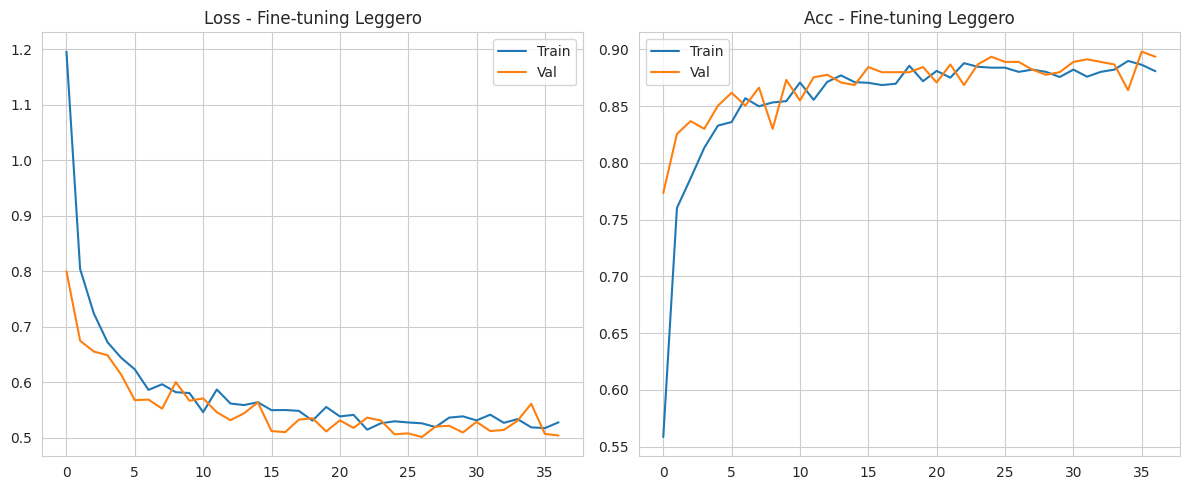

Salvato: best_model_finetuned_light.pth


In [ ]:
# ==============================================================================
# Cella 5 · Fine-tuning leggero (solo fc) + salvataggio
# ------------------------------------------------------------------------------
# Scopo
#   - Allena SOLO il layer finale (fully connected) della ResNet18.
#   - Salva i pesi in 'best_model_finetuned_light.pth' (compatibile con l’app).
#
# Note
#   - Usiamo CrossEntropy con label smoothing (0.05) per rendere il training
#     un po’ più tollerante a label rumorose.
#   - L’optimizer vede solo i parametri con requires_grad=True (cioè la fc).
#   - ReduceLROnPlateau osserva la val_loss: se non migliora per un po’,
#     riduce il learning rate (factor=0.1).
#   - Early stopping/pazienza sono gestiti dentro train_model().
# ==============================================================================

# Loss: CrossEntropy con label smoothing (aiuta su dataset eterogenei/rumorosi)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# Ottimizzatore: Adam SOLO sui parametri allenabili (la fc); un minimo di weight decay
optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_transfer.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

# Scheduler: riduce il LR quando la validation loss smette di migliorare
# - mode='min' → aspetta che la val_loss scenda
# - patience=7 → dopo 7 epoche senza miglioramenti, LR *= factor
# - min_lr=1e-8 → non scendere oltre questo LR
scheduler_ft = lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', patience=7, factor=0.1, min_lr=1e-8
)

# Training vero e proprio (usa la funzione definita nella cella 4)
# - num_epochs=60: massimo 60 epoche, ma si ferma prima se non migliora (patience=10)
# - phase_name è solo per le stampe e i grafici
model_stage1, *_ = train_model(
    model_transfer,
    criterion,
    optimizer_ft,
    scheduler_ft,
    num_epochs=60,
    patience=10,
    phase_name="Fine-tuning Leggero"
)

# Salvataggio SOLO dello state_dict (pesi) —> compatibile con l’app Flask,
# che ricrea la stessa architettura e poi carica questi pesi.
# ATTENZIONE: l’ordine delle classi deve essere quello usato nel training
# (final_class_names) e coincidere con quello hardcoded nell’app.
torch.save(model_stage1.state_dict(), 'best_model_finetuned_light.pth')
print("Salvato: best_model_finetuned_light.pth")


In [ ]:
# Cella 6: Valutazione Finale su Test
# --------------------------------------------------------------------------
# Scopo:
# - Caricare i pesi "leggeri" (solo fc) salvati in Cella 5: best_model_finetuned_light.pth
# - Valutare su test_loader: loss media e accuracy
# - Stampare matrice di confusione + classification_report
#
# Perché serve:
# - Verifica oggettiva delle prestazioni del modello pubblicato nell’app
# - Le stesse trasformazioni di test (Resize 256 → CenterCrop 224 → Normalize)
#   devono essere coerenti con quelle usate in app.py (trasform pipeline)

print("\n<<< Valutazione Finale (Stage 1) su Test >>>")

# Funzione di perdita per la valutazione (senza label smoothing)
criterion_eval = nn.CrossEntropyLoss()

# 1) Ricrea la ResNet18 con testa (fc) a num_classes
#    Nota: carichiamo i pesi "leggeri" (Stage-1), quindi testa già adattata a 5 classi.
model_final = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1  # backbone ImageNet
)
model_final.fc = nn.Linear(model_final.fc.in_features, num_classes)

# 2) Carica i pesi allenati nella Cella 5
model_final.load_state_dict(
    torch.load('best_model_finetuned_light.pth', map_location=device)
)

# 3) Sposta su device (GPU/CPU) e metti in modalità eval (niente dropout/BN update)
model_final.to(device)
model_final.eval()

# 4) Loop di valutazione su test_loader
running_loss = 0.0
running_corrects = 0
all_labels = []  # per report/matrice
all_preds  = []  # per report/matrice

with torch.no_grad():  # disabilita il grad per velocità + memoria
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model_final(inputs)
        _, preds = torch.max(outputs, 1)          # classe con logit massimo
        loss = criterion_eval(outputs, labels)    # CE su batch

        # accumuli per metriche
        bs = inputs.size(0)                       # batch size
        running_loss     += loss.item() * bs      # somma loss pesata
        running_corrects += torch.sum(preds == labels).item()
        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

# 5) Metriche aggregate
test_loss = running_loss / len(test_loader.dataset)
test_acc  = running_corrects / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f} ({test_acc*100:.2f}%)")

# 6) Matrice di confusione
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_class_names, yticklabels=final_class_names)
plt.title('Matrice di Confusione (Stage 1)')
plt.xlabel('Predetto'); plt.ylabel('Reale'); plt.show()

# 7) Report per-classe (precision/recall/f1)
print("\nClassification Report:")
print(classification_report(
    all_labels, all_preds,
    labels=list(range(num_classes)),
    target_names=final_class_names,
    zero_division=0  # evita warning se una classe non compare
))


In [ ]:
# Cella 6B: Calibrazione (Temperature Scaling) sulla Validation — SOLO Stage 1
# --------------------------------------------------------------------------
# Scopo:
# - Stimare la temperatura T tale che softmax(logits / T) migliori la calibrazione
#   (riduce la NLL su validation).
# - Salvare T in 'calibration.json' per l'app (che la applica in app.py se presente).
#
# Perché serve:
# - La confidenza (softmax) dei modelli può essere troppo "ottimista".
# - Il temperature scaling è un metodo post-hoc, semplice e robusto, per allineare
#   probabilità e frequenze empiriche osservate.
#
# Output:
# - File JSON con { "temperature": <float> }

import torch.nn.functional as F
import json

print("\n<<< Calibrazione (Temperature Scaling) su Validation – Stage 1 >>>")

# 1) Ricrea lo stesso modello Stage-1 e carica i pesi leggeri
model_for_calib = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
)
model_for_calib.fc = nn.Linear(model_for_calib.fc.in_features, num_classes)
model_for_calib.load_state_dict(torch.load('best_model_finetuned_light.pth', map_location=device))
model_for_calib.to(device)
model_for_calib.eval()

@torch.no_grad()
def learn_temperature(model, loader, device, grid=np.linspace(0.6, 3.0, 49)):
    """
    Stima T cercando su una griglia (0.6 → 3.0) il valore che minimizza
    la Negative Log-Likelihood (NLL) su validation.

    Dettagli:
    - logits: output grezzi del modello (prima della softmax)
    - logits/T: con T>1 "appiattisce" la distribuzione (meno confidenza)
    - cross_entropy(logits/T, labels): NLL equivalente a log-softmax + NLLLoss
    - Si potrebbe anche ottimizzare T via gradiente; la grid search è più semplice/stabile.
    """
    logits_all, labels_all = [], []
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        logits_all.append(model(x).cpu())
        labels_all.append(y.cpu())
    logits = torch.cat(logits_all)   # [N, num_classes]
    labels = torch.cat(labels_all)   # [N]

    best_T, best_nll = 1.0, float('inf')
    for T in grid:
        # cross_entropy accetta logits grezzi: noi dividiamo per T
        nll = F.cross_entropy(logits / T, labels).item()
        if nll < best_nll:
            best_nll, best_T = nll, float(T)
    return best_T

# 2) Stima T su validation
T = learn_temperature(model_for_calib, val_loader, device)

# 3) Salva JSON (consumato da app.py all'avvio)
with open('calibration.json', 'w') as f:
    json.dump({'temperature': float(T)}, f)

print(f"✔ Temperatura stimata T={T:.3f} salvata in calibration.json")



<<< Calibrazione (Temperature Scaling) su Validation >>>
✔ Temperatura stimata T=0.600 salvata in calibration.json


In [ ]:
# Cella 7: Packaging Artefatti per Deploy nell’App (SOLO Stage 1)
# --------------------------------------------------------------------------
# Scopo:
# - Creare una cartella versionata con:
#   * best_model_finetuned_light.pth  → pesi del modello usato dall’app
#   * calibration.json                → temperatura T (opzionale ma consigliata)
#   * class_index.json                → mappa indice→nome classe (usata in app)
# - Zippare la cartella e forzare il download in Colab.
#
# NOTE:
# - Copia lo zip e/o i singoli file nella root della tua app Flask (stesso livello di app.py)
# - In app.py, MODEL_PATH deve puntare a 'best_model_finetuned_light.pth'
# - Se 'calibration.json' non c’è, l’app usa T=1.0 (nessuna calibrazione)

from google.colab import files

# 1) Cartella versionata: timestamp per tracciabilità
MODEL_VERSION = datetime.now().strftime("%Y%m%d_%H%M%S")
ARTIFACTS_DIR = f"smart_waste_model_{MODEL_VERSION}"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# 2) Copia dei file essenziali (Stage-1 only)
for src in ['best_model_finetuned_light.pth', 'calibration.json']:
    if os.path.exists(src):
        shutil.copy(src, os.path.join(ARTIFACTS_DIR, src))
    else:
        print(f"[WARN] File non trovato e quindi non copiato: {src}")

# 3) class_index.json: l’app lo usa per mostrare la classe predetta umana
with open(os.path.join(ARTIFACTS_DIR, "class_index.json"), "w", encoding="utf-8") as f:
    json.dump({i: n for i, n in enumerate(final_class_names)}, f, ensure_ascii=False, indent=2)

# 4) Zip degli artefatti e download
zip_name = f"{ARTIFACTS_DIR}.zip"
shutil.make_archive(ARTIFACTS_DIR, 'zip', ARTIFACTS_DIR)
print(f"Creato: {zip_name}")

# 5) Avvia il download in Colab (puoi anche scaricare i singoli file a mano)
files.download(zip_name)

print("✅ Copia i file nella root della tua app (stesso livello di app.py).")
print("   - MODEL_PATH: best_model_finetuned_light.pth")
print("   - calibration.json (consigliato)")
print("   - class_index.json")
